# TP 3 : Embeddings

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP3%20-%20Word%20Embeddings/tp3-header.png?raw=True" width="1000">

On va s'appuyer sur le corpus collecté par <span class="badge badge-secondary">(Panckhurst et al., 2016)</span> qui rassemble 88,000 sms collectés dans la région de Montpellier. Le corpus a été dé-identifié (en particulier, les noms sont remplacés par [_forename_]). Pour chaque sms, on a identifié les Emojis dans le texte.

Il y avait beaucoup de type d'Emojis. Dans le TP, ils ont été simplifiés selon le tableau suivant. Tous les Emojis de la colonne `Emoji list` ont été remplacé par l'emoji de la colonne `Generic`. Dans le TP les Emojis n'apparaissent pas dans le texte du sms car on cherche à les prédire.


| Generic Emoji  | Emoji list                                                         |
|:--------------:|:------------------------------------------------------------------:|
| 😃             | '=P', ':)', ':P', '=)', ':p', ':d', ':-)', '=D', ':D', '^^'        |
| 😲             | ':O', 'o_o', ':o', ':&'                                            | 
| 😔             | '"-.-'''", '<_>', '-_-', "--'", "-.-'", '-.-', "-.-''", "-\_-'"    | 
| 😠             | ':/', ':-/', ':-(', ':(', ':-<'                                    | 
| 😆             | '>.<', '¤.¤', '<>','><', '*.*', 'xd', 'XD', 'xD', 'x)',';)', ';-)' | 
| 😍             | '</3', '<3'                                                        | 
 

Finalement pour le TP, on a filtré le jeu de données pour ne conserver que les sms contenant qu'un seul Emoji. On a par ailleurs <i>down samplé</i> les classes majoritaires pour limiter le déséquilibre du jeu de données. En effet les sms avec un smiley 😃 était largement sur-représentés.

<b>L'objet du TP est de prédire l'émoji associé à chaque message. Pour cela on vectorisera le texte en utilisant les méthodes d'embeddings.</b>

<span class="badge badge-secondary">(Panckhurst et al., 2016)</span> Panckhurst, Rachel, et al. "88milSMS. A corpus of authentic text messages in French." Banque de corpus CoMeRe. Chanier T.(éd)-Ortolang: Nancy (2016).

In [ ]:
# Execute if running in Colab
# %tensorflow_version 1.x

!pip install -q scikit-learn==0.23.2 matplotlib==3.3.2 pandas==1.1.3 gensim==3.8.3 torch==1.6.0 torchvision==0.7.0
!git clone https://github.com/AntoineSimoulin/m2-data-sciences.git

# puis redémarer l'environnement d'exécution

In [2]:
from gensim.models import KeyedVectors

from collections import Counter
import numpy as np
import pandas as pd
import re

import os, sys
sys.path.append(os.path.abspath('m2-data-sciences/src'))

# IPython automatically reload all changed code
%load_ext autoreload
%autoreload 2

# Inline Figures with matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'

On va utiliser les embeddings déjà entrainé que nous avons manipulé au cours précédent. Pour limiter la taille du fichier d'embeddings, on a sauvegardé que les `10,000` mots les plus fréquents. <b>Vous devez récupérer le fichier d'embeddings directement sur le Moodle.</b>

In [3]:
w2v_model = KeyedVectors.load_word2vec_format("oscar.fr.300.10k.model", unicode_errors='ignore')
w2v_model.init_sims(replace=True)

In [96]:
len(w2v_model.vocab)

10000

In [97]:
# On crée un array avec les 10,000 premiers mots et on crée le dictionaire de vocabulaire

word_count = {k: w2v_model.vocab[k].count for k in w2v_model.vocab}
word_count = Counter(word_count)
word_count.most_common(10)

idx2w = {i: w for (i, (w, f)) in enumerate(word_count.most_common(10000))}
w2idx = {w: i for (i, (w, f)) in enumerate(word_count.most_common(10000))}


embeddings_vectors = [w2v_model[w] for (w, f) in word_count.most_common(10000)]
word2vec_embeddings = np.vstack(embeddings_vectors)

<b>Vous devez récupérer le jeu de données directement sur le Moodle.</b>

In [9]:
dataset = pd.read_csv('emojis.csv')

In [10]:
dataset.head()

,Unnamed: 0,sms,happy,joke,astonished,angry,bored,heart,filter
0,3,Haha merci beaucoup . Tout se passe bien dans....,True,False,False,False,False,True,True
1,4,Oh trop mignon mon bbé jsuis au travaiiiil la,False,False,False,False,False,True,True
2,5,Bon alors jvais etre serieuse un ptit moment ....,False,True,False,False,False,True,True
3,6,Mon cher et tendre filleul... Je m'engage a et...,False,False,False,False,False,True,True
4,7,Ohhhhhh non ! Héhé j'te texto en mode scred mo...,False,False,False,False,False,True,True


In [69]:
class_names = ['happy', 'joke', 'astonished', 'angry', 'bored', 'heart']

In [13]:
dataset.shape

(6387, 9)

On va utiliser la même fonction de tokenization qui a été utilisée pour entrainer les embeddings.

In [14]:
token_pattern = re.compile(r"(\->|(?::\)|:-\)|:\(|:-\(|;\);-\)|:-O|8-|:P|:D|:\||:S|:\$|:@|8o\||\+o\(|\(H\)|\(C\)|\(\?\))|(?:[\d.,]+)|([^\s\w0-9])\2*|(?:[\w0-9\.]+['’]?)(?<!\.))")

def tokenize(text):
    tokens = [groups[0] for groups in re.findall(token_pattern, str(text))]
    tokens = [t.strip() for t in tokens]
    return tokens

In [15]:
dataset['tokens'] = dataset['sms'].apply(tokenize)

### Exploration de données

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Observer la distribution des classes.</p>
</div>    

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Evaluer la proportion de tokens qui sont hors du vocabulaire des embeddings.</p>
</div>    

In [77]:
# %load solutions/unk.py


### Vectorization

Les embeddings de mots permettent de représenter chaque <i>token</i> par un vecteur. Pour obtenir un vecteur qui représente le sms, on va agréger les différents mots du texte. On considérera plusieurs fonctions d'agrégation : la somme, la moyenne, me maximum ou le minimum.

En pratique nous verrons dans le dernier cours d'ouverture qu'il existe des méthodes plus évoluées pour composer les mots de la phrase. Néanmoins une simple fonction d'agrégation nous donnera déjà une bonne <i>baseline</i>.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP3%20-%20Word%20Embeddings/model.png?raw=True" width="500">

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Ecrire une fonction qui permet de vectoriser un sms.</p>
</div>    

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def vectorize(tokens, agg_method='mean'):
    
    #TODO à compléter
    
    # associer chaque token à son embedding. 
    # Attention, certains tokens peuvent ne pas être dans le vocabulaire
    
    # Agréger les représentations de chaque token.
    # Le vecteur de sortie doit être de taille (300, )
    
    if agg_method == 'mean':
        sentence_embedding = 
    elif agg_method == 'max':
        sentence_embedding = 
    elif agg_method == 'sum':
        sentence_embedding = 
    
    return
    

In [21]:
# %load solutions/vectorize_1.py


On voudrait attribuer un poids moins important aux embeddings des mots moins caractéristiques. Pour ça, on voudrait pondérer la contribution des vecteurs de chaque mot en fonction de leur score TF-IDF.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP3%20-%20Word%20Embeddings/model-tfidf.png?raw=True" width="700">

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Uiliser la pondération TF-IDF pour pondérer chacun des vecteurs</p>
</div>    

In [23]:
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x,
                                   lowercase=False)

tfidf_vectorizer.fit(dataset['tokens'])

w2idx_tfidf = {w: idx for (idx, w) in enumerate(tfidf_vectorizer.get_feature_names())}
idx_tfidf2w = {idx: w for (idx, w) in enumerate(tfidf_vectorizer.get_feature_names())}

In [ ]:
def vectorize(tokens, agg_method='mean', tfidf_vectorizer=None):
    
    #TODO à compléter
    
    if agg_method == 'mean':
        sentence_embedding = 
    elif agg_method == 'max':
        sentence_embedding = 
    elif agg_method == 'sum':
        sentence_embedding = 
    elif agg_method == 'tfidf':
        
    
    return
    

In [ ]:
# %load solutions/vectorize_2.py


In [28]:
X = [vectorize(t) for t in dataset['tokens']]
X = np.array(X)
print(X.shape)

(6387, 300)


On va intégrer la fonction `vectorize` dans un module compatible avec les fonctions de `sklearn`.

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Intégrer votre fonction de vectorization dans la classe Vectorizer ci-dessous. Vous devez simoplement la copier/coller en replaçant tfidf_vectorizer par self.tfidf_vectorizer car c'est maintenant un attribut de la class.</p>
</div>    

In [47]:
class Vectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, agg_method='mean', normalize=False):
        self.agg_method = agg_method
        self.normalize = normalize
        self.tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda x: x,
                                                lowercase=False,
                                                token_pattern=None)
        
    def vectorize(self, tokens):
        
        #TODO à compléter
        
        vectors = np.array([w2v_model[t] for t in tokens if t in w2v_model.vocab])
        
        if len(vectors) == 0:
            sentence_embedding = 
        elif len(vectors) == 1:
            sentence_embedding = 
        elif len(vectors) > 1:
            if self.agg_method == 'mean':
                sentence_embedding = 
            elif self.agg_method == 'max':
                sentence_embedding = 
            elif self.agg_method == 'sum':
                sentence_embedding = 
            elif self.agg_method == 'tfidf':
                
        return sentence_embedding
    
    def _vectorize(self, tokens):
        return vectorize(tokens)
    
    def fit(self, X, y=None): 
        self.tfidf_vectorizer.fit(X['tokens'])
        self.w2idx_tfidf = {w: idx for (idx, w) in enumerate(self.tfidf_vectorizer.get_feature_names())}
        self.idx_tfidf2w = {idx: w for (idx, w) in enumerate(self.tfidf_vectorizer.get_feature_names())}
        return self
    
    def transform(self, X, y=None):
        X = [self.vectorize(t) for t in X['tokens']]
        X = np.array(X)

        if self.normalize:
            X = X / np.linalg.norm(X + self.eps, axis=1, keepdims=True)
        return X

In [ ]:
# %load solutions/vectorizer.py


In [48]:
vectorizer = Vectorizer(agg_method='tfidf')

In [49]:
X = vectorizer.fit_transform(dataset)

### Classification

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, roc_auc_score

On compare deux algorithmes de classification :  Une régression logistique et un SVM ou l'on pénalise les classes majoritaires.

In [51]:
X_train, X_test = train_test_split(
    dataset, test_size=0.33, random_state=42)

y_train = X_train[['happy', 'joke', 'astonished', 'angry', 'bored', 'heart']].astype(int).values
y_train = [x.tolist().index(1) for x in y_train]

y_test = X_test[['happy', 'joke', 'astonished', 'angry', 'bored', 'heart']].astype(int).values
y_test = [x.tolist().index(1) for x in y_test]

In [52]:
len(y_train)

4279

In [53]:
X_train.shape

(4279, 10)

In [54]:
LogReg_pipeline = Pipeline([
    ('vect', Vectorizer()),
    ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'))),
])


# Training logistic regression model on train data
LogReg_pipeline.fit(X_train, y_train)

# Infering data on test set
prediction_LogReg = LogReg_pipeline.predict(X_test)

In [55]:
SVC_pipeline = Pipeline([
    ('vect', Vectorizer(agg_method='tfidf')),
    ('clf', OneVsRestClassifier(SVC(kernel='linear', 
                                    class_weight='balanced', # penalize
                                    probability=True), n_jobs=-1))
])


SVC_pipeline.fit(X_train, y_train)
prediction_SVC = SVC_pipeline.predict(X_test)

### Evaluation

In [66]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from plots import plot_confusion_matrix

Test accuracy is 0.325426944971537
Test ROC socre is 0.6845136821641983
Confusion matrix, without normalization


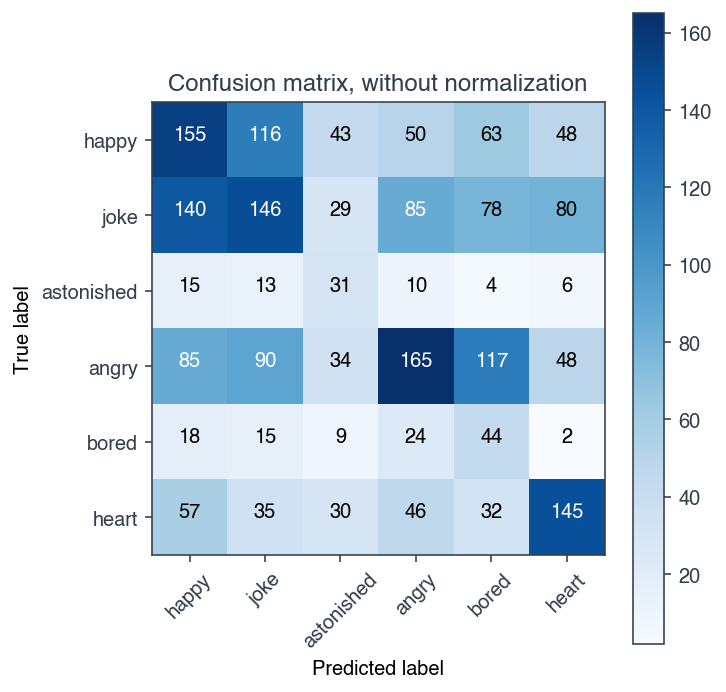

In [74]:
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction_SVC)))
print('Test ROC socre is {}'.format(roc_auc_score(np.eye(np.max(y_test) + 1)[y_test],
                                                  SVC_pipeline.predict_proba(X_test), 
                                                  multi_class='ovo')))

plot_confusion_matrix(confusion_matrix(y_test, prediction_SVC), 
                      classes=class_names, 
                      title='Confusion matrix, without normalization')

Test accuracy is 0.3752371916508539
Test ROC socre is 0.6787592648363906
Confusion matrix, without normalization


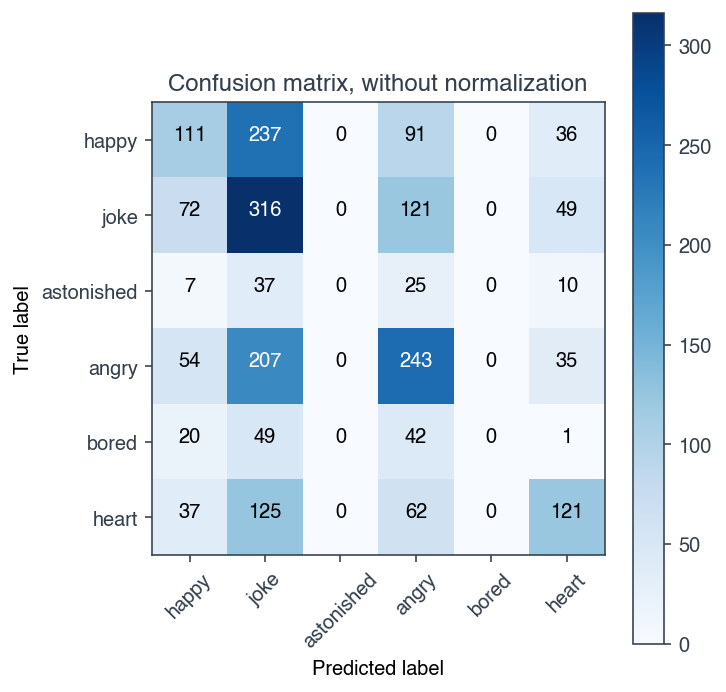

In [75]:
print('Test accuracy is {}'.format(accuracy_score(y_test, prediction_LogReg)))
print('Test ROC socre is {}'.format(roc_auc_score(np.eye(np.max(y_test) + 1)[y_test],
                                                  LogReg_pipeline.predict_proba(X_test), 
                                                  multi_class='ovo')))

plot_confusion_matrix(confusion_matrix(y_test, prediction_LogReg), 
                      classes=class_names, 
                      title='Confusion matrix, without normalization')

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Quelle mesure de performance vous semble le plus adaptée pour ce cas d'usage ?</p>
</div>    

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Comparer les résultats obtenus avec les deux algorithmes de classifications</p>
</div>    

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Comparer les différentes méthodes d'agrégation proposées. (Mean, Max, Sum, Moyenne pondérée par le TF-IDF)</p>
</div>    

L'utilisation des méthodes de down-sampling ou up-sampling peut s'avérer fastidieux (on va se priver de données ou en utiliser d'autres plusieurs fois. La sélection des données doit se faire précisémment pour ne pas impacter les capacités de généralisation de l'algorithme). Nous avons préféré ici utiliser un algorithme qui pénalise les classes majoritaires et une mesure d'erreur adaptée. Il existe un bon article de blog pour gérer les classes déséquilibrées : https://elitedatascience.com/imbalanced-classes. 

On peut se faire une idée des limites et des points fort de l'algorithme en regardant des prédictions.

In [84]:
humors = ['happy', 'astonished', 'bored', 'angry', 'joke', 'heart']
meta_smiley = [b'\xF0\x9F\x98\x83'.decode("utf-8"),
                b'\xF0\x9F\x98\xB2'.decode("utf-8"),
                b'\xF0\x9F\x98\x94'.decode("utf-8"), 
                b'\xF0\x9F\x98\xA0'.decode("utf-8"),
                b'\xF0\x9F\x98\x86'.decode("utf-8"),
                b'\xF0\x9F\x98\x8D'.decode("utf-8")]
humor_2_emoji = {h: ms for (h, ms) in zip(humors, meta_smiley)}

In [86]:
X_test.shape

(2108, 10)

In [89]:
for _ in range(10):
    idx = np.random.randint(0, len(X_test))
    
    emojis = humor_2_emoji[class_names[prediction_SVC[idx]]]
    
    true_emojis = humor_2_emoji[class_names[y_test[idx]]]
    print(X_test['sms'].values[idx], '(Pred)', emojis, '(True)', true_emojis, '\n')
    

Mais pk tu peux pas me dire ? Rappel toi d'au moins 2,3 trucs vu qu'tu m'le dis pas trop sur le coup lol (Pred) 😠 (True) 😠 

J espere j espere! Ca fait vmt super lgtps. [_forename_] [_forename_] tu manques. (Pred) 😍 (True) 😍 

Vien ici on fera le tour de Montpellier mdr! ça ferai pas pareil que le tour de sirach ! (Pred) 😆 (True) 😆 

c'est méme pas moi qui t'ai faite changer d'avis (Pred) 😆 (True) 😠 

Et votre crémaillère aura lieu quand ? ? En 2013 ? je vais essayer de m'occuper du cadeau de val. (Pred) 😠 (True) 😃 

Mais mes parents veulent qu'on en "discute" car ils disent que va pas être facil si j'y vais ... D'un côté ils ont pas tord mais j'ai tellement envie de vous revoir que même si c'est pour m'ennuier pendant une semaine... Je VEUX venir ! (Pred) 😔 (True) 😠 

3 chemises, celle que t'as vu, une blanche en lin, et une blanche rayé bleu. Au pire il peut changer. Et un ptit livre de culture générale, c'est les questions qu'on ne sait jamais posé, c'est sympa. Voilou on se voit de

### Visualisation

On peut aussi essayer de visualiser plus globalement les représentations. Pour ça on peut utiliser des algorithmes de réduction de dimension pour visualiser nos données. On a déjà parlé de UMAP et t-SNE. De manière intutive, l'algorithme projete les représentations dans un espace de plus faible dimension en s'efforcant de respecter les distances entre les points entre l'espace de départ et d'arrivée. Il permet de visualiser facilement les données. On va utiliser l'outil `Tensorboard` qui intègre les principales méthodes de réduction de dimensions.

In [79]:
from pathlib import Path
from PIL import Image
import os
from os import listdir
from os.path import isfile, join
from torchvision import transforms

from torch.utils.tensorboard import SummaryWriter
import torch

In [ ]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

In [81]:
smileys_images = [f for f in listdir('m2-data-sciences/TP3 - Word Embeddings/smileys') if isfile(join('m2-data-sciences/TP3 - Word Embeddings/smileys', f))]

In [82]:
imgs_tb = {}
for s in smileys_images:
    pil_img = Image.open(os.path.join('m2-data-sciences/TP3 - Word Embeddings/smileys', s)).convert('RGB')
    pil_img = pil_img.resize((25, 25)) 
    pil_to_tensor = transforms.ToTensor()(pil_img).unsqueeze_(0)
    imgs_tb[Path(os.path.join('smileys', s)).stem] = pil_to_tensor

In [448]:
writer_embeddings = SummaryWriter(log_dir=os.path.join("./tfb/"))

vectorizer = Vectorizer(agg_method='tfidf', normalize=True)
emb_test = vectorizer.fit_transform(X_test)

writer_embeddings.add_embedding(torch.tensor(emb_test),
                                metadata=[(r, s, l) for (r, s, l) in zip(
                                    X_test['sms'].values,
                                    [humor_2_emoji[class_names[y]] for y in y_test],
                                    [humor_2_emoji[class_names[y]] for y in prediction_SVC])
                                ],
                                label_img=torch.cat([imgs_tb[class_names[y]] for y in y_test]),
                                metadata_header=['sms','label', 'prediction'],
                                tag="SMS-EMB-CLS")

Pour visualiser les représentations, lancer un tensorboard. Dans un terminal, se placer dans le dossier ou est éxécuté le notebook et exécuter:

```
tensorboard --logdir ./tfb/
```

Dans **Colab** on va lancer le tensorboard directement dans le notebook en éxécutant les cellules suivante :

```
%load_ext tensorboard
```

```
%tensorboard --logdir ./tfb/
```

La compatibilité entre Colab et Tensorboard est un peu instable en ce moment. Je vous conseille donc de télécharger le dossier directement sur votre ordinateur.

```
!zip -r tfb.zip ./tfb/
```

Téléchargez le .zip, sur votre ordinateur, dezipé le. Puis, dans un terminal, se placer dans le dossier ou est éxécuté le notebook et exécuter:

```
tensorboard --logdir ./tfb/
```

Vous devriez avoir un visuel comme ci-dessous. Vous pouvez cliquer sur un sms et vous avez à droite les sms les plus proches en terme de distance cosine comme nous l'avons fait pour word2vec. Par ailleurs chaque sms est représenté par le smiley correspondant. Vous pouvez faire varier les méthodes de projection dans le panneau de gauche.

<img src="https://github.com/AntoineSimoulin/m2-data-sciences/blob/master/TP3%20-%20Word%20Embeddings/tfb-viz.png?raw=True" width="1000">

<div class="alert alert-info" role="alert">
    <p><b>Exercice :</b> Utiliser les méthodes UMAP, PCA et t-SNE pour projeter les données. Comparez les différentes méthodes de projections et interprétez qualitativement les propriétés de vos représentations.</p>
</div>    